# Business Scenario:
You are a data analyst and your client has a large ecommerce company in India (let’s call it X). X gets a thousand orders via their website on a daily basis and they have to deliver them as fast as they can. For delivering the goods ordered by the customers, X has tied up with multiple courier companies in India as delivery partners who charge them some amount per delivery. The charges are dependent upon two factors:

● Weight of the product

● Distance between the warehouse (pickup location) and customer’s delivery address (destination location)

On an average, the delivery charges are Rs. 100 per shipment. So if X ships 1,00,000 orders per month, they have to pay approximately Rs. 1 crore to the courier companies on a monthly basis as charges.

As the amount that X has to pay to the courier companies is very high, they want to verify if the charges levied by their Delivery partners per Order are correct.

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Input Data
Left Hand Side (LHS) Data (X’s internal data spread across three reports)

● Website order report- which will list Order IDs and various products (SKUs) part of each order. Order ID is common identifier between X’s order report and courier company invoice

● Warehouse pincode to All India pincode mapping -(this should be used to figure out delivery zone (a/b/c/d/e) and during analysis compare against one reported by courier company in their CSV invoice per Order ID

● SKU master with gross weight of each product. This should be used to calculate total weight of each order and during analysis compare against one reported by courier company in their CSV invoice per Order ID. The courier company calculates weight in slabs that is applicable for that delivery zone, so first you have to figure out the total weight of the shipment and then figure out applicable weight (based on zone’s weight slab)

Company - Order Report

In [53]:
data = pd.read_excel('Company X - Order Report.xlsx')
data

,ExternOrderNo,SKU,Order Qty,Payment Mode,Item Price(Per Qty.)
0,2001827036,8904223818706,1,COD,233
1,2001827036,8904223819093,1,COD,233
2,2001827036,8904223819109,1,COD,233
3,2001827036,8904223818430,1,COD,470
4,2001827036,8904223819277,1,COD,233
...,...,...,...,...,...
395,2001806229,8904223818942,1,COD,286
396,2001806229,8904223818850,1,COD,563
397,2001806226,8904223818850,2,COD,1125
398,2001806210,8904223816214,1,COD,402


In [54]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ExternOrderNo         400 non-null    int64 
 1   SKU                   400 non-null    object
 2   Order Qty             400 non-null    int64 
 3   Payment Mode          400 non-null    object
 4   Item Price(Per Qty.)  400 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 15.8+ KB


In [55]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
ExternOrderNo,400.0,2.001811e+09,5187.698443,2.001806e+09,2.001807e+09,2.001809e+09,2.001812e+09,2.001827e+09
Order Qty,400.0,1.297500e+00,0.919842,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
Item Price(Per Qty.),400.0,7.166850e+02,846.795629,1.680000e+02,2.860000e+02,5.630000e+02,8.100000e+02,7.814000e+03


In [56]:
for i in data.columns:
    print(data[i].value_counts(),'\n','-'*50)

2001809820    14
2001827036     8
2001812854     8
2001821185     8
2001817093     8
              ..
2001814580     1
2001820690     1
2001806686     1
2001806823     1
2001807012     1
Name: ExternOrderNo, Length: 124, dtype: int64 
 --------------------------------------------------
8904223818850    60
8904223818706    59
8904223818942    41
8904223819468    24
8904223819024    17
                 ..
8904223819093     1
8904223817501     1
8904223819109     1
GIFTBOX202002     1
8904223818645     1
Name: SKU, Length: 65, dtype: int64 
 --------------------------------------------------
1    334
2     48
4     11
8      3
6      3
3      1
Name: Order Qty, dtype: int64 
 --------------------------------------------------
Prepaid    216
COD        184
Name: Payment Mode, dtype: int64 
 --------------------------------------------------
233     74
563     57
286     39
603     22
402     11
        ..
574      1
729      1
916      1
806      1
1673     1
Name: Item Price(Per Qty.), Le

<Axes: xlabel='Order Qty', ylabel='count'>

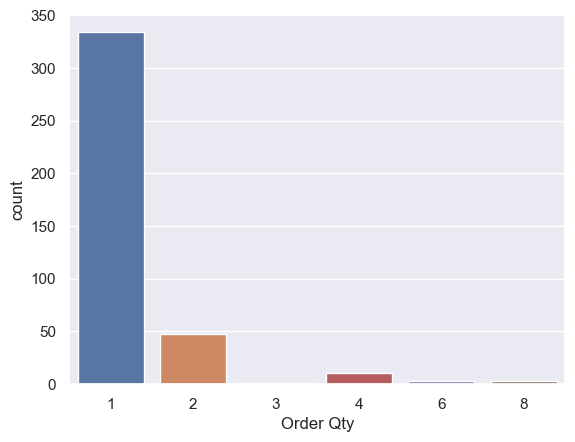

In [57]:
sns.countplot(x=data['Order Qty'])

In [58]:
col = ['ExternOrderNo','SKU']


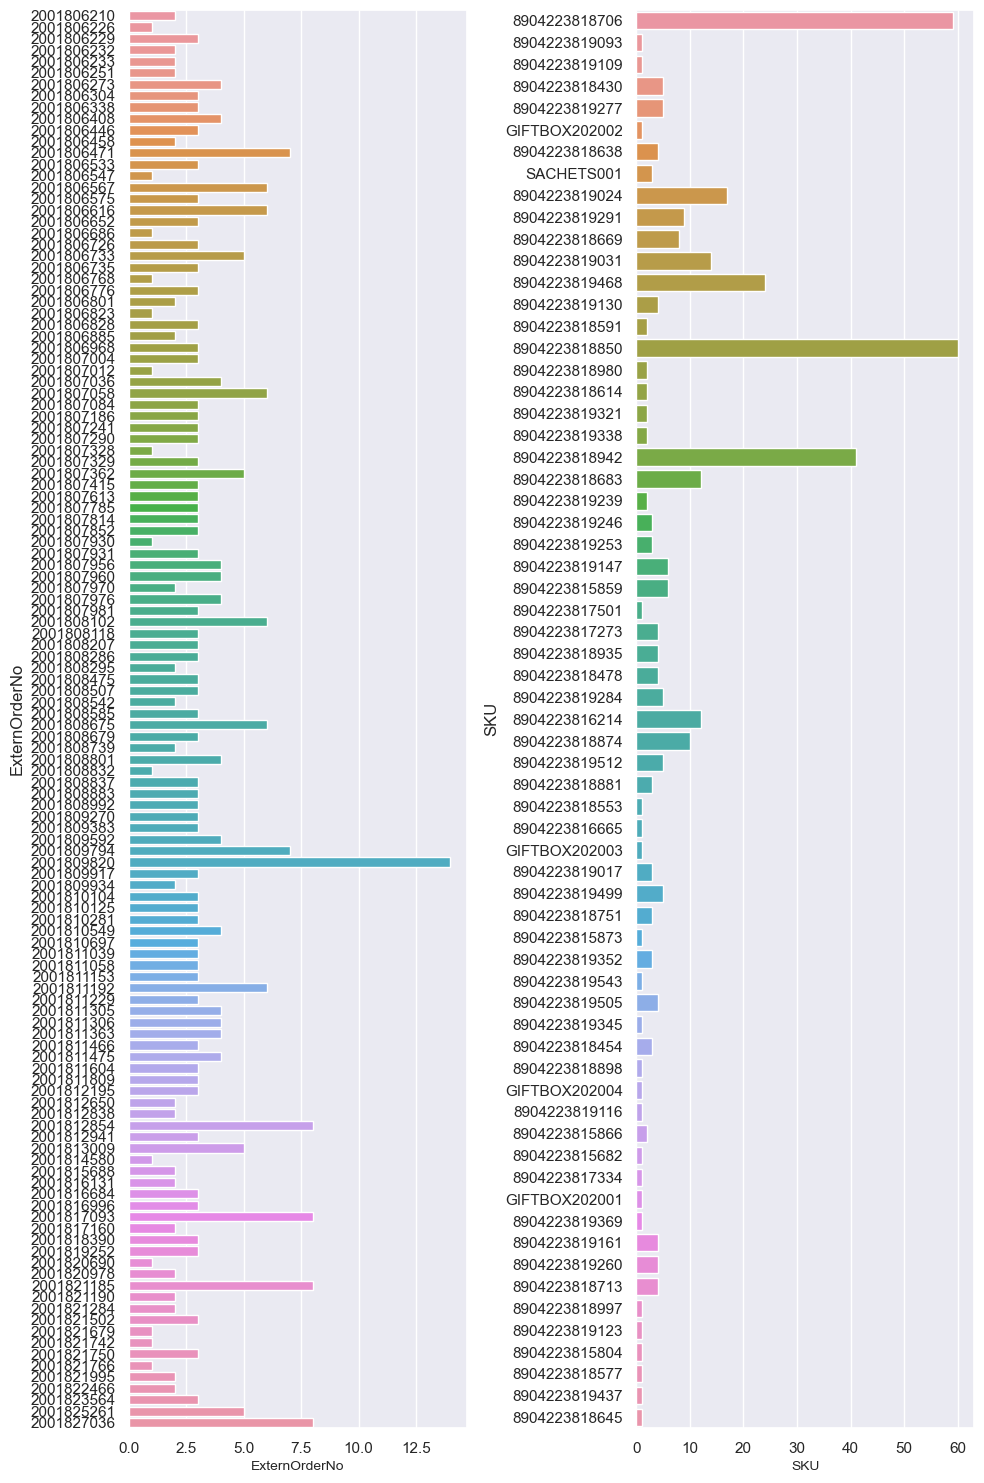

In [59]:
plt.figure(figsize = (10,15))
plotnumber = 1

for column in col:
    if plotnumber <= 2:
        ax = plt.subplot(1,2,plotnumber)
        sns.countplot(y = data[column])
        plt.xlabel(column,fontsize = 10)
    
    plotnumber+=1
plt.tight_layout()

# Unique Values

*ExternOrderNo. have 124 unique values.

*SKU have 65 unique values.

*Order Qty, 6 unique values.

Highest

*Order No. : 2001809820, is the highest no. of data in ExternOrderNo.

*8904223818850, is the highest in SKU.

*Maximum Order Qty is 1.0

Company - Pincode Zone

In [60]:
data1 = pd.read_excel('Company X - Pincode Zones.xlsx')
data1

,Warehouse Pincode,Customer Pincode,Zone
0,121003,507101,d
1,121003,486886,d
2,121003,532484,d
3,121003,143001,b
4,121003,515591,d
...,...,...,...
119,121003,325207,b
120,121003,303702,b
121,121003,313301,b
122,121003,173212,e


In [61]:
data1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Warehouse Pincode  124 non-null    int64 
 1   Customer Pincode   124 non-null    int64 
 2   Zone               124 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.0+ KB


In [62]:
data1.describe().T


,count,mean,std,min,25%,50%,75%,max
Warehouse Pincode,124.0,121003.000000,0.00000,121003.0,121003.0,121003.0,121003.00,121003.0
Customer Pincode,124.0,365488.072581,152156.32213,140301.0,302017.0,321304.5,405102.25,845438.0


*124 data present in the dataset.

*No null values present.

*Warehouse Pincode and Customer Pincode are integer type.

*Zone is object type column.

In [63]:
for i in data1.columns:
    print(data1[i].value_counts(),'\n','-'*50)

121003    124
Name: Warehouse Pincode, dtype: int64 
 --------------------------------------------------
302017    5
313001    4
302002    2
302031    2
248001    2
         ..
723146    1
140604    1
831006    1
562110    1
313301    1
Name: Customer Pincode, Length: 108, dtype: int64 
 --------------------------------------------------
b    79
d    38
e     7
Name: Zone, dtype: int64 
 --------------------------------------------------


<Axes: xlabel='Zone', ylabel='count'>

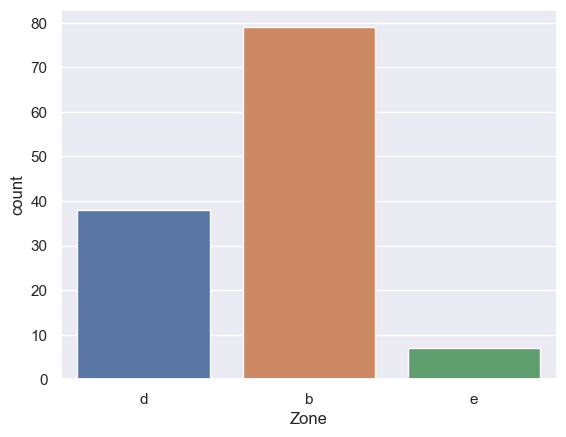

In [64]:
sns.countplot(x=data1['Zone'])

<Axes: xlabel='count', ylabel='Customer Pincode'>

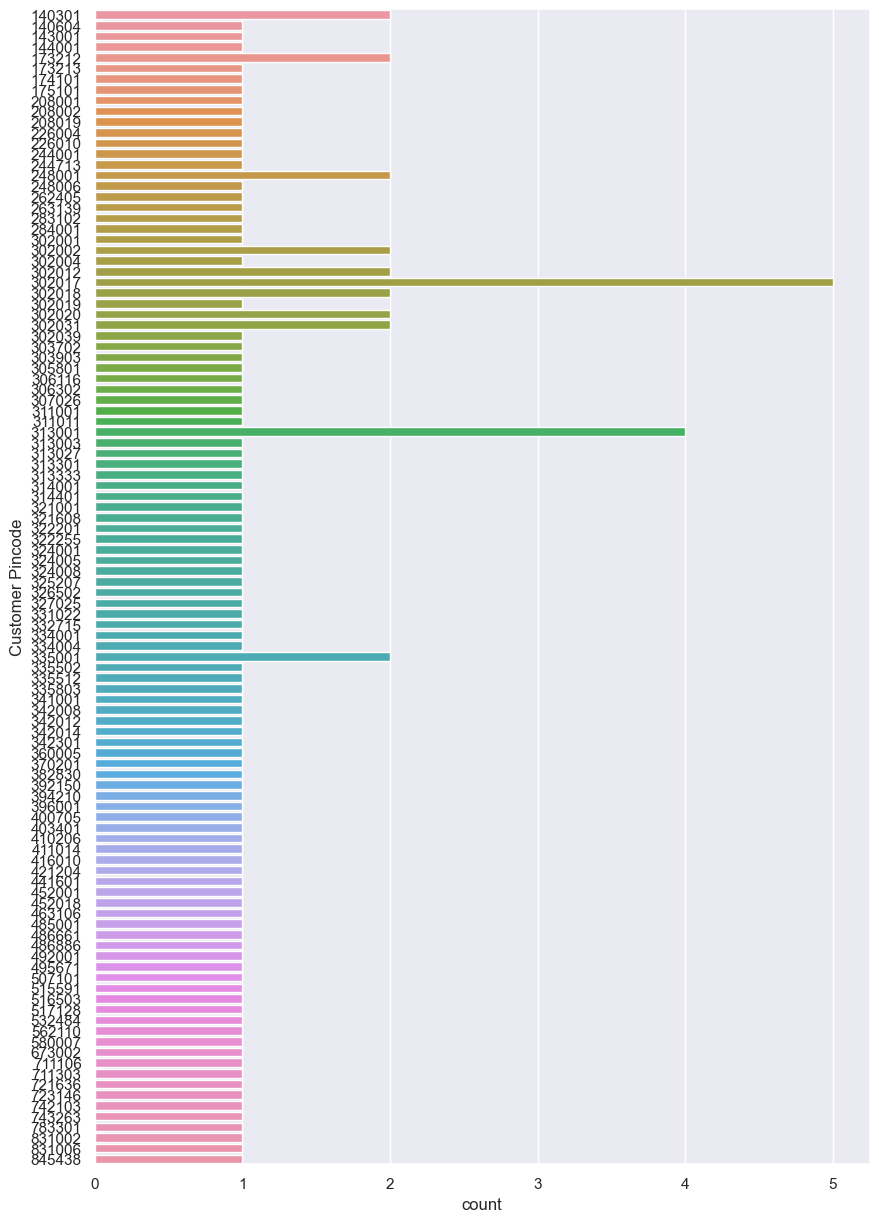

In [65]:
plt.figure(figsize = (10,15))
sns.countplot(y = data1['Customer Pincode'])

*There is only 1 warehouse pincode i.e. 121003.

*Customer Pincode has 108 unique values and Maximum is from 302017 customer pincode.

*3 unique values in Zone and Maximum zone is b.

In [66]:
data2 = pd.read_excel('Company X - SKU Master.xlsx')
data2

,SKU,Weight (g)
0,8904223815682,210
1,8904223815859,165
2,8904223815866,113
3,8904223815873,65
4,8904223816214,120
...,...,...
61,8904223819505,210
62,8904223819499,210
63,8904223819512,210
64,8904223819543,300


In [67]:
data2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SKU         66 non-null     object
 1   Weight (g)  66 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [68]:
data2.describe()


,Weight (g)
count,66.000000
mean,219.742424
std,146.855482
min,10.000000
25%,116.250000
50%,165.000000
75%,290.000000
max,600.000000


*66 data are present.

*No null values.

*SKU is object type.

*Weight (g) is integer type column.

In [69]:
for i in data2.columns:
    print(data2[i].value_counts(),'\n','-'*50)

GIFTBOX202002    2
8904223815682    1
8904223819291    1
8904223819116    1
8904223819161    1
                ..
8904223818997    1
8904223818942    1
8904223819024    1
8904223819031    1
SACHETS001       1
Name: SKU, Length: 65, dtype: int64 
 --------------------------------------------------
500    5
350    5
210    4
120    4
165    4
240    4
115    3
112    3
290    3
65     3
150    2
140    2
170    2
600    2
100    2
113    2
137    2
130    1
250    1
300    1
552    1
232    1
30     1
110    1
133    1
490    1
160    1
127    1
121    1
102    1
10     1
Name: Weight (g), dtype: int64 
 --------------------------------------------------


<Axes: xlabel='count', ylabel='Weight (g)'>

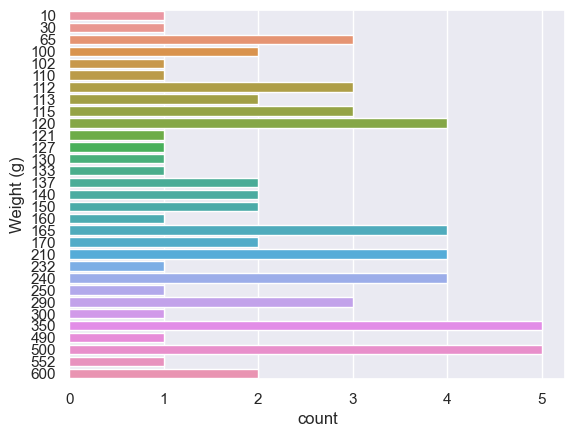

In [70]:
sns.countplot(y = data2['Weight (g)'])

<Axes: xlabel='count', ylabel='SKU'>

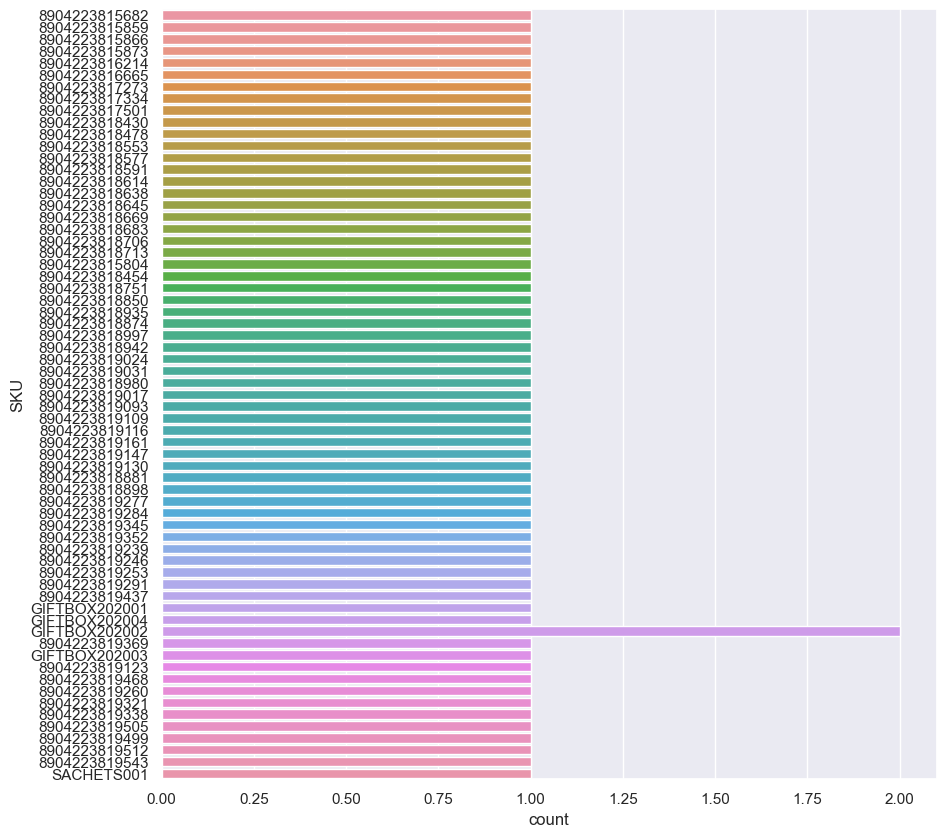

In [71]:
plt.figure(figsize = (10,10))
sns.countplot(y = data2['SKU'])

*Only SKU no. GIFTBOX202002 is twice a time, else others are single unit.

*Maximum weight(g) are 500g and 350g.

In [72]:
company = pd.merge(data, data2, on = 'SKU', how = 'inner')
company

,ExternOrderNo,SKU,Order Qty,Payment Mode,Item Price(Per Qty.),Weight (g)
0,2001827036,8904223818706,1,COD,233,127
1,2001821995,8904223818706,1,Prepaid,233,127
2,2001819252,8904223818706,1,Prepaid,233,127
3,2001816996,8904223818706,1,Prepaid,233,127
4,2001814580,8904223818706,1,COD,233,127
...,...,...,...,...,...,...
396,2001806616,8904223819123,1,COD,442,250
397,2001806567,8904223815804,1,COD,834,160
398,2001806567,8904223818577,1,COD,946,150
399,2001806408,8904223819437,2,Prepaid,1843,552


RHS Data (courier company invoice in CSV file)

● Invoice in CSV file mentioning AWB Number (courier company’s own internal ID), Order ID (company X’s order ID), weight of shipment, warehouse pickup pincode, customer delivery pincode, zone of delivery, charges per shipment, type of shipment

● Courier charges rate card at weight slab and pincode level. If the invoice mentions “Forward charges” then only forward charges (“fwd”) should be applicable as per zone and fixed & additional weights based on weight slabs. If the invoice mentions “Forward and rto charges” then forward charges (“fwd”) and RTO charges (“rto”) should be applicable as per zone and fixed & additional weights based on weight slabs.

● For the first slab of that zone, “fixed” rate as per the slab is applicable. For each additional slab, “additional” weight in the same proportion is applicable. Total charges will be “fixed” + “total additional” if any. For example: weight 2.2KG, Zone C. So for Zone C the slab length = 0.75KG. So the total applicable weight = 2.25KG. For the first 0.75 KG the charge is “fwd”, and for each 0.75 after the first, charges will be additional charges.

In [73]:
data3 = pd.read_excel('Courier Company - Invoice.xlsx')
data3

,AWB Code,Order ID,Charged Weight,Warehouse Pincode,Customer Pincode,Zone,Type of Shipment,Billing Amount (Rs.)
0,1091117222124,2001806232,1.30,121003,507101,d,Forward charges,140.0
1,1091117222194,2001806273,1.00,121003,486886,d,Forward charges,101.2
2,1091117222931,2001806408,2.50,121003,532484,d,Forward charges,224.6
3,1091117223244,2001806458,1.00,121003,143001,b,Forward charges,61.3
4,1091117229345,2001807012,0.15,121003,515591,d,Forward charges,45.4
...,...,...,...,...,...,...,...,...
119,1091118551656,2001812941,0.73,121003,325207,d,Forward charges,95.2
120,1091117614452,2001809383,0.50,121003,303702,d,Forward and RTO charges,86.7
121,1091120922803,2001820978,0.50,121003,313301,d,Forward charges,45.4
122,1091121844806,2001811475,0.50,121003,173212,b,Forward charges,47.0


In [74]:
col3 = ['AWB Code','Order ID','Charged Weight','Warehouse Pincode','Customer Pincode','Zone','Type of Shipment','Billing Amount (Rs.)']


In [75]:
for i in col3:
    print(data3[i].value_counts(),'\n','-'*50)

1091117222124    1
1091120962515    1
1091117227116    1
1091117222360    1
1091122418320    1
                ..
1091117222135    1
1091117222080    1
1091117222065    1
1091117221940    1
1091121846136    1
Name: AWB Code, Length: 124, dtype: int64 
 --------------------------------------------------
2001806232    1
2001821284    1
2001806768    1
2001806304    1
2001827036    1
             ..
2001806233    1
2001806229    1
2001806226    1
2001806210    1
2001811305    1
Name: Order ID, Length: 124, dtype: int64 
 --------------------------------------------------
0.50    11
0.68    10
1.00     7
0.70     6
0.15     6
0.72     6
0.80     5
0.20     5
0.79     4
0.60     4
0.69     4
0.67     3
0.73     2
1.30     2
1.50     2
1.10     2
0.76     2
0.71     2
1.13     2
0.59     2
1.60     2
1.20     2
1.08     2
0.82     1
1.86     1
0.61     1
2.10     1
0.66     1
0.30     1
1.04     1
2.94     1
2.47     1
2.28     1
0.74     1
4.13     1
1.63     1
1.02     1
1.35     1
0.77   

# Univariate Analysis



<Axes: xlabel='Zone', ylabel='count'>

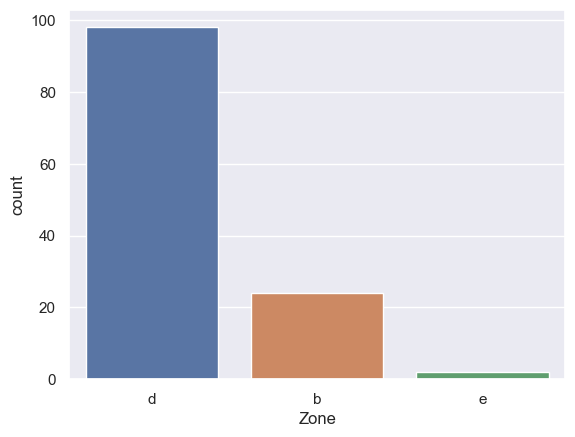

In [76]:
sns.countplot(x = data3['Zone'])


*The courier compny has to deliever only in 3 zones.

*Zone D has the highest amount of orders.

*Then Zone B

*And Zone E has the least amout of orders.

<Axes: xlabel='Type of Shipment', ylabel='count'>

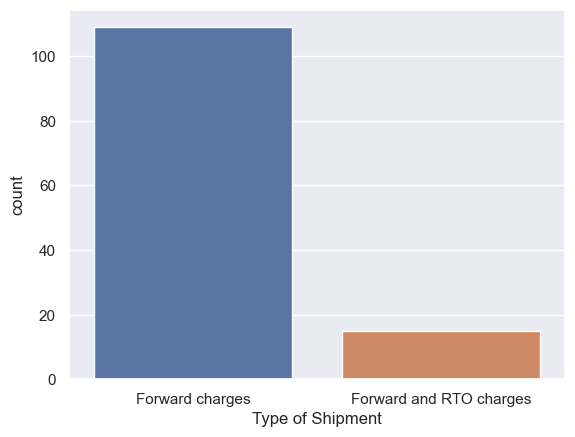

In [77]:
sns.countplot(x = data3['Type of Shipment'])


*Only 2 types of shipments are there 1. Forward charges. 2. Forward and RTO charges

*Forward and RTO charges are very less then Forward charges.

# Bivariate Analysis



In [78]:
def scatter(x,y,data):
    plt.figure()
    plt.scatter(x,y,data=data3)
    plt.xlabel(x)
    plt.ylabel(y)
    print('Scatterpot between',x,'and',y)
    plt.show()

Scatterpot between Zone and Customer Pincode


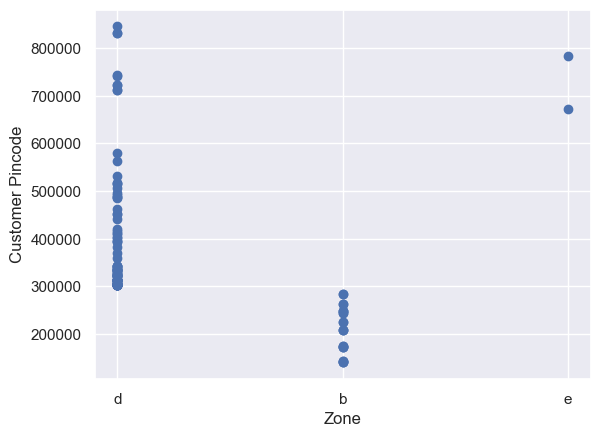

In [79]:
scatter (x = 'Zone', y = 'Customer Pincode', data = data3)


*Most of the customer are in zone d.

*Most of the pincodes are in zone d.

Scatterpot between Zone and Billing Amount (Rs.)


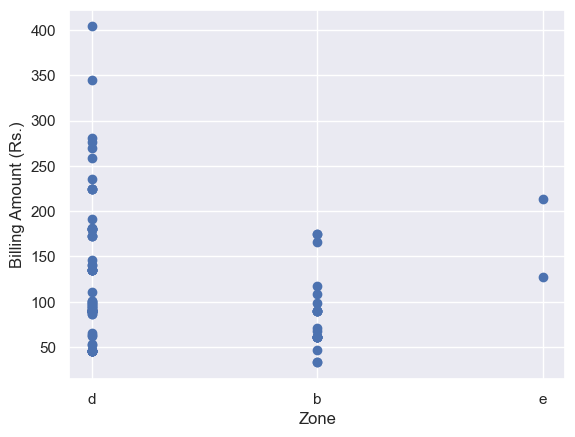

In [80]:
scatter (x = 'Zone', y = 'Billing Amount (Rs.)', data = data3)


In terms of Billing Amount.

*Billing amount for Zone d is from 50 to 400.

*Zone b billing amount is from 40 to 180.

*And Zone e is the lowest, as there are very less orders from that zone.

Scatterpot between Type of Shipment and Billing Amount (Rs.)


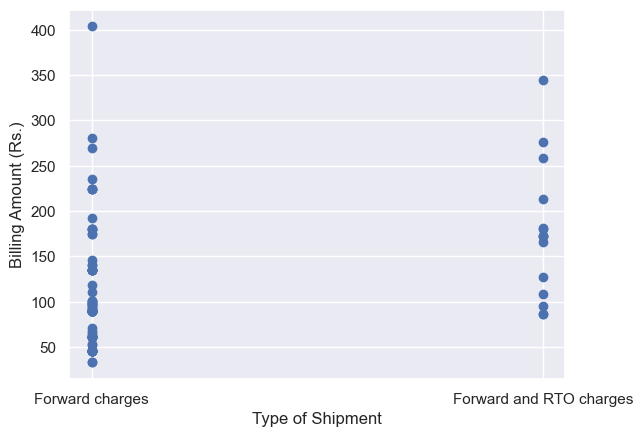

In [81]:
scatter (x = 'Type of Shipment', y = 'Billing Amount (Rs.)', data = data3)


In terms of Billing Amount.

*Foward charges are from range 40 to 400

*Forward charges and RTO charges are from range 90 to 350

Scatterpot between Charged Weight and Billing Amount (Rs.)


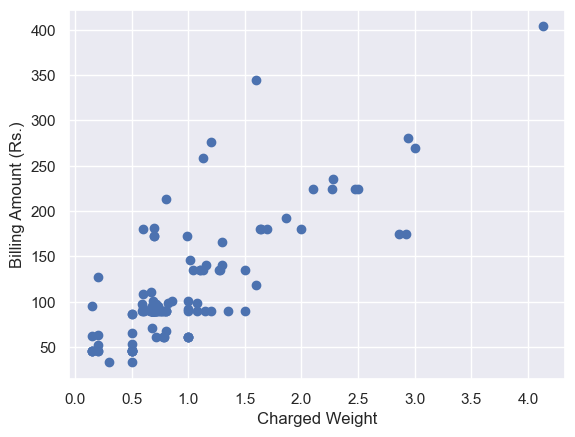

In [82]:
scatter (x = 'Charged Weight', y = 'Billing Amount (Rs.)', data = data3)


*Graph is in increasing order.

*As the weight increase, billing amount is also increasing.

# Mering Datasets.



In [83]:
company.rename(columns = {'ExternOrderNo':'Order ID'}, inplace = True)


In [84]:
data4 = pd.merge(company, data3, on="Order ID",how = 'inner')


In [85]:
data4

,Order ID,SKU,Order Qty,Payment Mode,Item Price(Per Qty.),Weight (g),AWB Code,Charged Weight,Warehouse Pincode,Customer Pincode,Zone,Type of Shipment,Billing Amount (Rs.)
0,2001827036,8904223818706,1,COD,233,127,1091122418320,1.60,121003,173213,b,Forward charges,117.9
1,2001827036,8904223819093,1,COD,233,150,1091122418320,1.60,121003,173213,b,Forward charges,117.9
2,2001827036,8904223819109,1,COD,233,100,1091122418320,1.60,121003,173213,b,Forward charges,117.9
3,2001827036,8904223818430,1,COD,470,165,1091122418320,1.60,121003,173213,b,Forward charges,117.9
4,2001827036,8904223819277,1,COD,233,350,1091122418320,1.60,121003,173213,b,Forward charges,117.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2001806251,8904223819161,1,Prepaid,810,115,1091117222146,1.27,121003,743263,d,Forward charges,135.0
397,2001806251,8904223819260,1,Prepaid,676,130,1091117222146,1.27,121003,743263,d,Forward charges,135.0
398,2001806233,8904223819161,1,Prepaid,810,115,1091117222135,0.78,121003,263139,b,Forward charges,61.3
399,2001806233,8904223819260,1,Prepaid,676,130,1091117222135,0.78,121003,263139,b,Forward charges,61.3


In [86]:
data4.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 401 entries, 0 to 400
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Order ID              401 non-null    int64  
 1   SKU                   401 non-null    object 
 2   Order Qty             401 non-null    int64  
 3   Payment Mode          401 non-null    object 
 4   Item Price(Per Qty.)  401 non-null    int64  
 5   Weight (g)            401 non-null    int64  
 6   AWB Code              401 non-null    int64  
 7   Charged Weight        401 non-null    float64
 8   Warehouse Pincode     401 non-null    int64  
 9   Customer Pincode      401 non-null    int64  
 10  Zone                  401 non-null    object 
 11  Type of Shipment      401 non-null    object 
 12  Billing Amount (Rs.)  401 non-null    float64
dtypes: float64(2), int64(7), object(4)
memory usage: 43.9+ KB


In [87]:
data4.describe()


,Order ID,Order Qty,Item Price(Per Qty.),Weight (g),AWB Code,Charged Weight,Warehouse Pincode,Customer Pincode,Billing Amount (Rs.)
count,4.010000e+02,401.000000,401.000000,401.000000,4.010000e+02,401.000000,401.0,401.000000,401.000000
mean,2.001811e+09,1.296758,716.541147,181.566085,1.091118e+12,1.116534,121003.0,358744.940150,125.766833
std,5.244070e+03,0.918811,845.741378,92.583321,1.534932e+06,0.712407,0.0,145882.764283,69.238237
min,2.001806e+09,1.000000,168.000000,10.000000,1.091117e+12,0.150000,121003.0,140301.000000,33.000000
25%,2.001807e+09,1.000000,286.000000,121.000000,1.091117e+12,0.680000,121003.0,302012.000000,90.200000
50%,2.001809e+09,1.000000,563.000000,133.000000,1.091117e+12,0.800000,121003.0,314401.000000,90.200000
75%,2.001812e+09,1.000000,810.000000,240.000000,1.091119e+12,1.300000,121003.0,410206.000000,166.100000
max,2.001827e+09,8.000000,7814.000000,600.000000,1.091122e+12,4.130000,121003.0,845438.000000,403.800000


<Axes: xlabel='Zone', ylabel='count'>

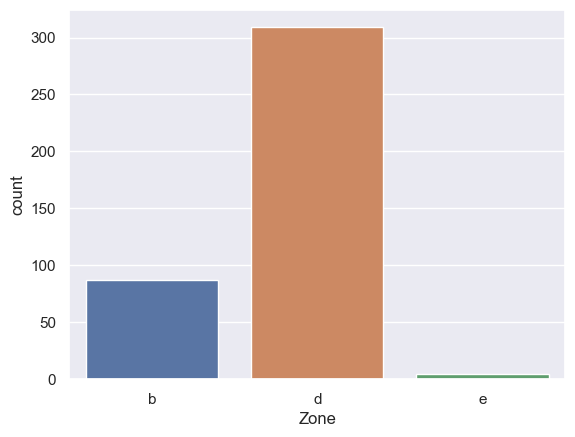

In [88]:
sns.countplot(x = data4['Zone'])


No difference found



<Axes: xlabel='Type of Shipment', ylabel='count'>

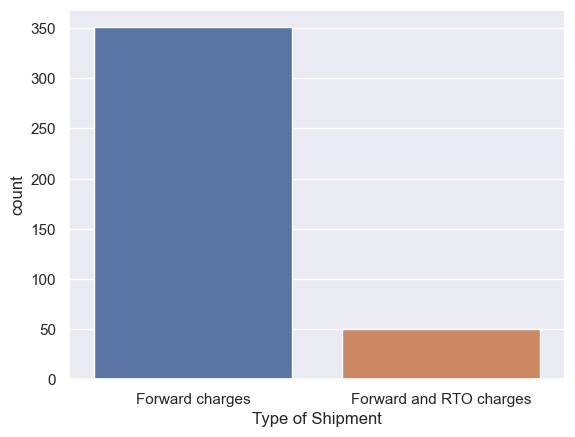

In [89]:
sns.countplot(x=data4['Type of Shipment'])


No difference found



<Axes: xlabel='count', ylabel='Weight (g)'>

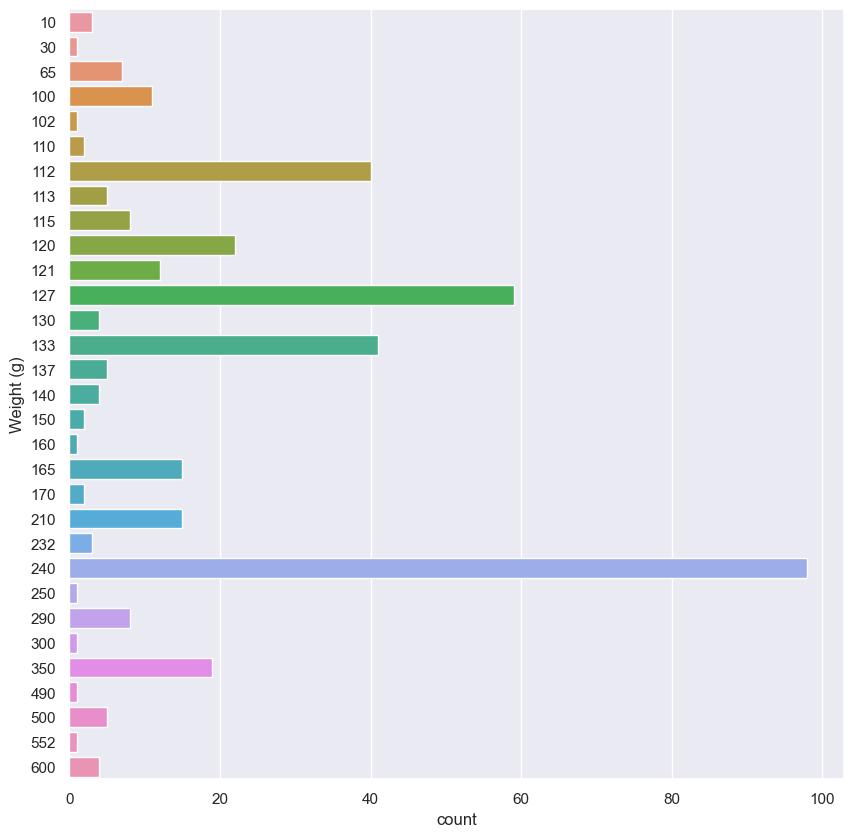

In [90]:
plt.figure(figsize = (10,10))
sns.countplot(y = 'Weight (g)', data = data4)

*Highest weightis 240 KG counts approx 96-98 times.

*Then 127 KG counts approx 56-58 times.

*Lowest count is 552 KG, 490 KG, 300 KG, 250 KG, 160 KG, 102 KG, 30 KG.

Scatterpot between Zone and Billing Amount (Rs.)


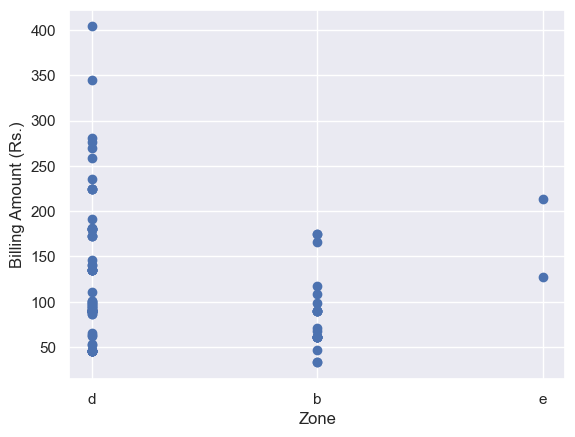

In [91]:
scatter(x = 'Zone', y = 'Billing Amount (Rs.)', data = data4)


No difference found



<Axes: xlabel='Zone', ylabel='Billing Amount (Rs.)'>

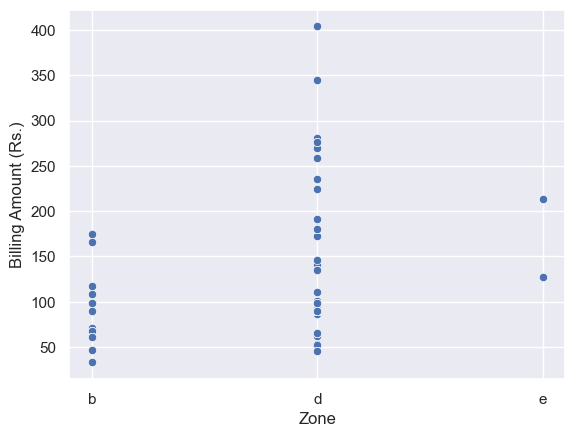

In [92]:
sns.scatterplot(x = data4['Zone'], y = data4['Billing Amount (Rs.)'])


In [93]:
data5 = pd.read_excel('Courier Company - Rates.xlsx')
data5

,Zone,Weight Slabs,Forward Fixed Charge,Forward Additional Weight Slab Charge,RTO Fixed Charge,RTO Additional Weight Slab Charge
0,A,0.25,29.5,23.6,13.6,23.6
1,B,0.50,33.0,28.3,20.5,28.3
2,C,0.75,40.1,38.9,31.9,38.9
3,D,1.25,45.4,44.8,41.3,44.8
4,E,1.50,56.6,55.5,50.7,55.5


Creating the expected dataset based on weight slab's data



In [138]:
import pandas as pd

data = [
    {'Zone': 'A', 'Weight Slabs': 0.25, 'Forward Fixed Charge': 29.50, 'Forward Additional Weight Slab Charge': 23.60,
     'RTO Fixed Charge': 13.60, 'RTO Additional Weight Slab Charge': 23.60},
    {'Zone': 'B', 'Weight Slabs': 0.50, 'Forward Fixed Charge': 33.00, 'Forward Additional Weight Slab Charge': 28.30,
     'RTO Fixed Charge': 20.50, 'RTO Additional Weight Slab Charge': 28.30},
    {'Zone': 'C', 'Weight Slabs': 0.75, 'Forward Fixed Charge': 40.10, 'Forward Additional Weight Slab Charge': 38.90,
     'RTO Fixed Charge': 31.90, 'RTO Additional Weight Slab Charge': 38.90},
    {'Zone': 'D', 'Weight Slabs': 1.25, 'Forward Fixed Charge': 45.40, 'Forward Additional Weight Slab Charge': 44.80,
     'RTO Fixed Charge': 41.30, 'RTO Additional Weight Slab Charge': 44.80},
    {'Zone': 'E', 'Weight Slabs': 1.50, 'Forward Fixed Charge': 56.60, 'Forward Additional Weight Slab Charge': 55.50,
     'RTO Fixed Charge': 50.70, 'RTO Additional Weight Slab Charge': 55.50}
]

expected_df = pd.DataFrame(data)

In [144]:
df = pd.read_csv('Data.csv')


In [145]:
output = {
    'Order ID': df['Order ID'].tolist(),
    'Total weight as per X (KG)': df['Total weight as per X (KG)'].tolist(),
    'Delivery Zone as per X': df['Delivery Zone as per X'].tolist(),
    'Type of Shipment': df['Type of Shipment'].tolist(),
    'Weight slab as per X (KG)': df['Weight slab as per X (KG)'].tolist()
}

In [146]:
expected = pd.DataFrame({'Order ID':output['Order ID'],'Weight':output['Total weight as per X (KG)'],'Zone':output['Delivery Zone as per X'],'Shipment':output['Type of Shipment'],'slab':output['Weight slab as per X (KG)']})


In [147]:
expected['round'] = expected['Weight']/expected['slab']


In [148]:
expected['round'] = expected['round'].apply(np.ceil)


In [149]:
expected['round'] = expected['round'].astype('int')


- Forward Fixed Charge and Forward Additional Weight Slab Charge columns



In [150]:
def condi_(x):
    if x == 'b':
        return 33.3
    
    elif x == 'd':
        return 45.4
    
    else:
        return 56.6

In [151]:
def condi_(x):
    if x == 'b':
        return 28.3
    
    elif x == 'd':
        return 44.8
    
    else:
        return 55.5

In [152]:
expected['FFC'] = expected['Zone'].apply(condi_)

In [153]:
expected['FAW'] = expected['Zone'].apply(condi_)

- Price Per Weight Column.



In [154]:
df = []
for i in expected['round']:
    if i <= 1:
        df.append(expected['FFC']) 
    elif i == 2:
        df.append(expected['FFC']+expected['FAW'])
    else:
        while(i <= 1):
            a = expected['FFC']
            b = expected['FAW']
            for i in range(1, i-1):
                c = a + b
                a = b
                b = c
            df.append(b)

In [155]:
expected['Price per weight'] = df[0]


In [156]:
expected

,Order ID,Weight,Zone,Shipment,slab,round,FFC,FAW,Price per weight
0,2001827036,1.27,b,Forward charges,0.50,3,28.3,28.3,56.6
1,2001827036,1.50,b,Forward charges,0.50,3,28.3,28.3,56.6
2,2001827036,1.00,b,Forward charges,0.50,2,28.3,28.3,56.6
3,2001827036,1.65,b,Forward charges,0.50,4,28.3,28.3,56.6
4,2001827036,3.50,b,Forward charges,0.50,7,28.3,28.3,56.6
...,...,...,...,...,...,...,...,...,...
328,2001806251,1.15,d,Forward charges,1.25,1,44.8,44.8,89.6
329,2001806251,1.30,d,Forward charges,1.25,2,44.8,44.8,89.6
330,2001806233,1.15,b,Forward charges,0.50,3,28.3,28.3,56.6
331,2001806233,1.30,b,Forward charges,0.50,3,28.3,28.3,56.6


# Output Dataset
Create a resultant CSV/Excel file with the following columns:

● Order ID

● AWB Number

● Total weight as per X (KG)

● Weight slab as per X (KG)

● Total weight as per Courier Company (KG)

● Weight slab charged by Courier Company (KG)

● Delivery Zone as per X

● Delivery Zone charged by Courier Company

● Expected Charge as per X (Rs.)

● Charges Billed by Courier Company (Rs.)

● Difference Between Expected Charges and Billed Charges (Rs.)

In [157]:
output = pd.DataFrame({'Order ID' : data4['Order ID'],'AWB Number' : data4['AWB Code'],'Total weight as per X (KG)':data4['Weight (g)'],'Weight slab charged by Courier Company (KG)':data4['Charged Weight'],'Delivery Zone as per X':data4['Zone'],'Delivery Zone charged by Courier Company':data4['Zone'],'Type of Shipment':data4['Type of Shipment']})


In [158]:
output['Total weight as per X (KG)'] = output['Total weight as per X (KG)']/100


In [159]:
slab = []
for i in data4['Zone']:
    if i == 'b':
        slab.append(0.50)
        
    elif i == 'd':
        slab.append(1.25)
    
    else:
        slab.append(1.50)

In [160]:
output['Weight slab as per X (KG)'] = slab


In [161]:
output['Expected Charge as per X (Rs.)'] = expected['Price per weight']


In [162]:
output['Charges Billed by Courier Company (Rs.)'] = data4['Billing Amount (Rs.)']


In [163]:
output['Difference Between Expected Charges and Billed Charges (Rs.)'] = output['Charges Billed by Courier Company (Rs.)'] - output['Expected Charge as per X (Rs.)']


In [164]:
output.drop_duplicates(inplace = True)


In [127]:
output

,Order ID,AWB Number,Total weight as per X (KG),Weight slab charged by Courier Company (KG),Delivery Zone as per X,Delivery Zone charged by Courier Company,Type of Shipment,Weight slab as per X (KG),Expected Charge as per X (Rs.),Charges Billed by Courier Company (Rs.),Difference Between Expected Charges and Billed Charges (Rs.)
0,2001827036,1091122418320,1.27,1.60,b,b,Forward charges,0.50,56.6,117.9,61.3
1,2001827036,1091122418320,1.50,1.60,b,b,Forward charges,0.50,56.6,117.9,61.3
2,2001827036,1091122418320,1.00,1.60,b,b,Forward charges,0.50,56.6,117.9,61.3
3,2001827036,1091122418320,1.65,1.60,b,b,Forward charges,0.50,56.6,117.9,61.3
4,2001827036,1091122418320,3.50,1.60,b,b,Forward charges,0.50,56.6,117.9,61.3
...,...,...,...,...,...,...,...,...,...,...,...
396,2001806251,1091117222146,1.15,1.27,d,d,Forward charges,1.25,NaN,135.0,NaN
397,2001806251,1091117222146,1.30,1.27,d,d,Forward charges,1.25,NaN,135.0,NaN
398,2001806233,1091117222135,1.15,0.78,b,b,Forward charges,0.50,NaN,61.3,NaN
399,2001806233,1091117222135,1.30,0.78,b,b,Forward charges,0.50,NaN,61.3,NaN


In [117]:
output.to_csv('Final_output.csv')


Final Result



In [128]:
data6 = pd.read_excel('Expected_Result.xlsx')
data6

,Unnamed: 0,Count,Amount
0,Total Orders - Correctly Charged,1.0,135.0
1,Total Orders - Over Charged,1.0,-141.5
2,Total Orders - Under Charged,NaN,NaN


- Counts for Correctly Charged



In [165]:
x_equal = 0
for i in output['Difference Between Expected Charges and Billed Charges (Rs.)']:
    if i == 0:
        x_equal += 1
x_equal

10

- Counts and Amount of Over Charger.



In [166]:
x_over = 0
for i in output['Difference Between Expected Charges and Billed Charges (Rs.)']:
    if i > 0:
        x_over += 1
x_over

227

In [167]:
x = []
for i in output['Difference Between Expected Charges and Billed Charges (Rs.)']:
    if i > 0:
        x.append(i)
over = sum(x)

- Counts and Amount of Under Charger.



In [168]:
x_under = 0
for i in output['Difference Between Expected Charges and Billed Charges (Rs.)']:
    if i < 0:
        x_under += 1
x_under

50

In [169]:
y = []
for i in output['Difference Between Expected Charges and Billed Charges (Rs.)']:
    if i < 0:
        y.append(i)
under = sum(y)

In [170]:
data6['Count'][0] = x_equal
data6['Count'][1] = x_over
data6['Count'][2] = x_under

In [171]:
data6['Amount'][0] = np.nan
data6['Amount'][1] = over
data6['Amount'][2] = under

-Final Results



In [172]:
data6

,Unnamed: 0,Count,Amount
0,Total Orders - Correctly Charged,10.0,NaN
1,Total Orders - Over Charged,227.0,12088.8
2,Total Orders - Under Charged,50.0,-1289.9


In [137]:
data6.to_csv('Final_result.csv')